In [24]:
import sys
import datacube
dc = datacube.Datacube(app = 'my_app', config = '/home/localuser/.datacube.conf')
from skimage.morphology import square,dilation
sys.path.append(r'/home/localuser/Datacube/data_cube_notebooks/cloudless')
from datetime import datetime
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scripts.data import *
from scripts.combiner import *
from scripts.view import *
import time
import cv2
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor #Multilayer perceptron 
from sklearn import linear_model,metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, max_error,mean_absolute_error,mean_squared_error
from sklearn.metrics import mean_squared_log_error, median_absolute_error, r2_score
from sklearn.svm import LinearSVR

In [25]:
def NDVI(composite):
    return ((composite[3,:,:] - composite[0,:,:])/(composite[3,:,:] + composite[0,:,:]))[np.newaxis,:,:]
def intensity(composite):
    return ((0.42*composite[2,:,:]+0.98*composite[1,:,:]+0.6*composite[0,:,:]+composite[3,:,:])/3)[np.newaxis,:,:]

In [19]:
clear_comp = np.load('test.npy')
Y_TRUE =  np.load('Y_true.npy')

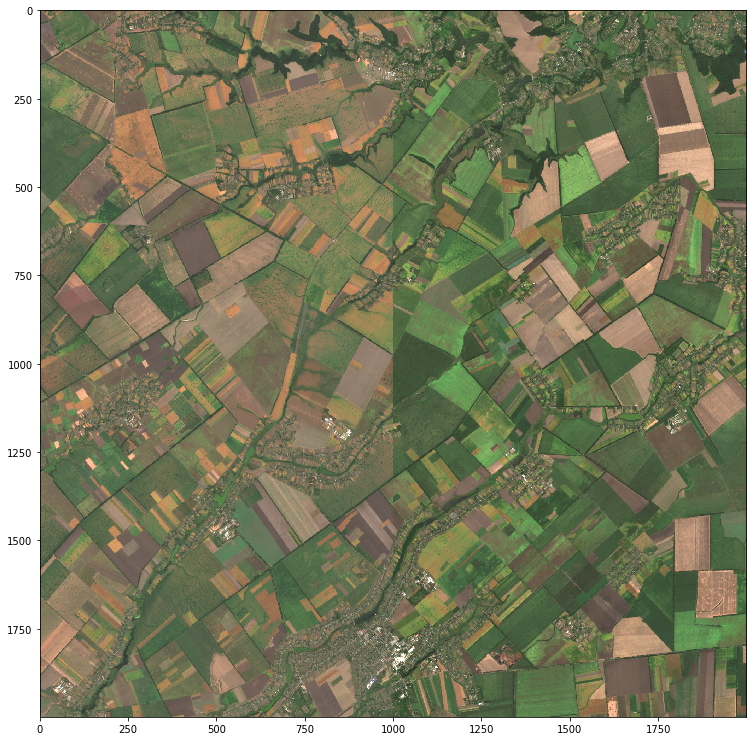

In [4]:
plot_composite(5*clear_comp)

# Вибираємо зону стику, де пертинаються навчальні дані.

In [20]:
region_op = clear_comp[:,:,800:1100] # опорний
region_neop = clear_comp[:,:,900:1200] #неопорний

In [5]:
region_neop.shape, region_op.shape

((4, 2000, 300), (4, 2000, 300))

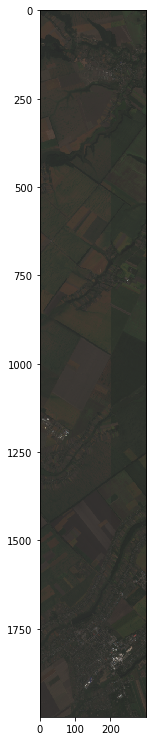

In [6]:
plot_composite(region_op)

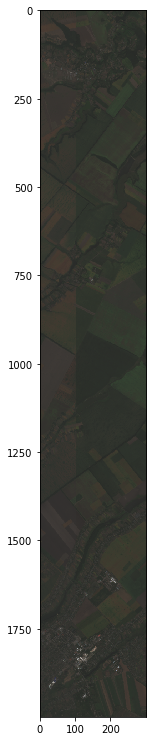

In [7]:
plot_composite(region_neop)

In [21]:
from sklearn.model_selection import train_test_split
def preparing_data(region_op, region_neop):
    #creating data
    X  = np.copy(region_neop)
    Y = np.copy(region_op)
    X_test = clear_comp[:,:,1000:]
    y_test = clear_comp [:,:,:1000]
    
    #adding two bands
    X = np.vstack([X,NDVI(X),intensity(X)])
    Y = np.vstack([Y,NDVI(Y),intensity(Y)])
    X_test = np.vstack([X_test,intensity(X_test), NDVI(X_test)])
    y_test = np.vstack([y_test,intensity(y_test), NDVI(y_test)])
    
    #reshaping
    X = np.moveaxis(X,0,-1)
    Y = np.moveaxis(Y,0,-1)
    X_test = np.moveaxis(X_test,0,-1).reshape(-1,6)
    y_test = np.moveaxis(y_test,0,-1).reshape(-1,6)
    
    #spliting
    X_train, x_None, y_train, y_None = train_test_split(X ,Y, test_size=1, random_state=42)
    X_train = X_train.reshape(-1,6)
    y_train = y_train.reshape(-1,6)
    x_None = None
    y_None = None
    
    #scaling
    for i in range(6):
        X_train[:,i] = StandardScaler().fit_transform(X_train[:,i].reshape(-1,1)).ravel()
        X_test[:,i] = StandardScaler().fit_transform(X_test[:,i].reshape(-1,1)).ravel()
    
    # X_train now is scaled
    # X_test now is scaled
    return (X_train, X_test, y_train, y_test)

In [22]:
import time

def try_rfr(prepeared_data):
    X_train_scaled = prepeared_data[0]
    X_test_scaled = prepeared_data[1]
    y_train = prepeared_data[2]
    y_test = prepeared_data[3]
    
    result = np.empty_like(X_test_scaled)
    print(X_train_scaled.shape)
    bands = X_train_scaled.shape[1]
    
    
    for i in range(3):
        print('band',i)
        a = time.time()
        
        scaler_y =  StandardScaler().fit(y_train[:,i].reshape(-1,1))
        scaler_y_test = StandardScaler().fit(y_test[:,i].reshape(-1,1))
    
        Y_train_scaled = scaler_y.transform(y_train[:,i].reshape(-1,1))
        Y_test_scaled= scaler_y_test.transform(y_test[:,i].reshape(-1,1))
        
        
        
        rfr = RandomForestRegressor(criterion='mse',
                                    n_estimators=500,
                                    min_samples_split=7,
                                    min_samples_leaf=19,
                                    max_features='sqrt',
                                    n_jobs=-1)
        #print('Train the model using the training sets')
        
        rfr.fit(X_train_scaled, Y_train_scaled.ravel())
        print("Time trainning:",(time.time()-a)/60,'min')
        train_time = time.time()
        
        #print('Make predictions using the testing set')
        Y_pred_scaled = rfr.predict(X_test_scaled)
              
        print("Time predicting:",(time.time()-train_time)/60,'min')
    
        #print('svr score: %.4f' % svr.score(X_test, Y_test))
        
        
        #X_test = scaler_x_test.inverse_transform(X_test_scaled)
        Y_pred = scaler_y_test.inverse_transform(Y_pred_scaled)
        Y_test = scaler_y_test.inverse_transform(Y_test_scaled)
        
        print('mean_absolute_error', mean_absolute_error(Y_test, Y_pred))
        print('r2_score',r2_score(Y_test, Y_pred))
        
        result[:,i] = Y_pred.ravel()
    
    result= result.reshape((2000,1000,bands))
    return result

In [7]:
prepeared_data = preparing_data(region_op,region_neop)
res = try_rfr(prepeared_data)
res = np.moveaxis(res, 2,0)

(599700, 6)
band 0
Time trainning: 4.332492423057556 min
Time predicting: 0.5731761455535889 min
mean_absolute_error 249.63025662511663
r2_score -0.016940685397554667
band 1
Time trainning: 4.252599243323008 min
Time predicting: 0.5665202339490255 min
mean_absolute_error 132.18608447142893
r2_score -0.02148926132570672
band 2
Time trainning: 4.097353291511536 min
Time predicting: 0.5597132126490275 min
mean_absolute_error 100.10506131350223
r2_score -0.03326460129094677


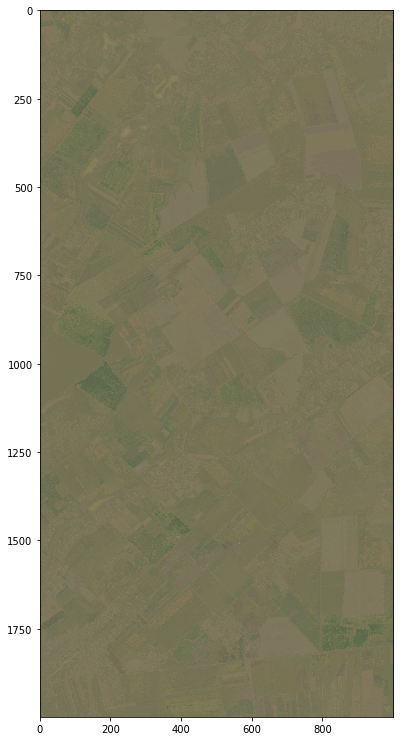

In [8]:
plot_composite(5*res.astype(float))

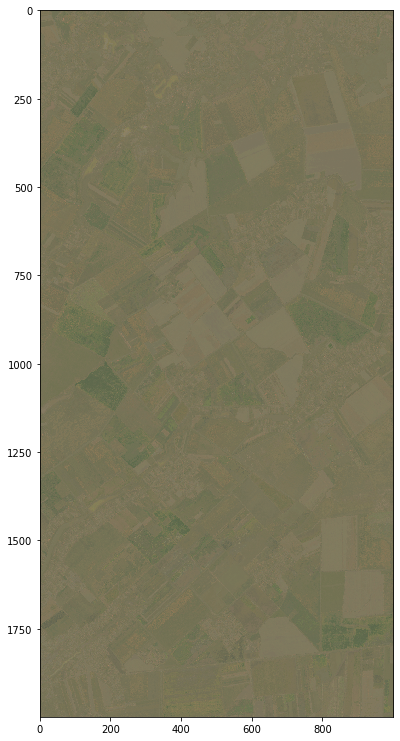

In [15]:
#criterion='mse',n_estimators=600,min_samples_split=10,min_samples_leaf=10, max_features='sqrt', n_jobs=-1
plot_composite(5*res.astype(float))

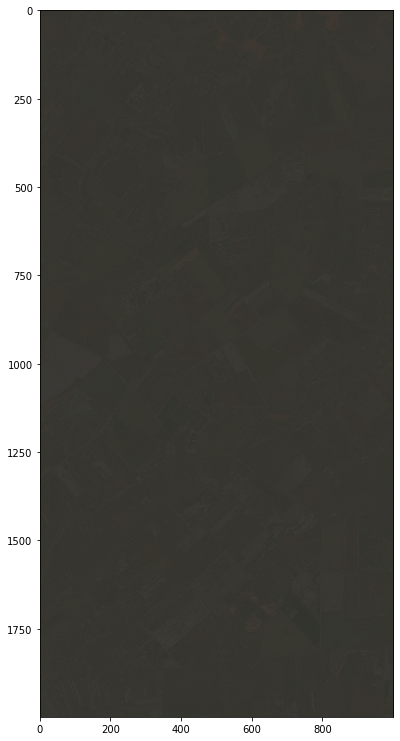

In [20]:
#criterion='mse',n_estimators=300,min_samples_split=4,min_samples_leaf=2, max_features='sqrt', n_jobs=-1
plot_composite(res.astype(float))

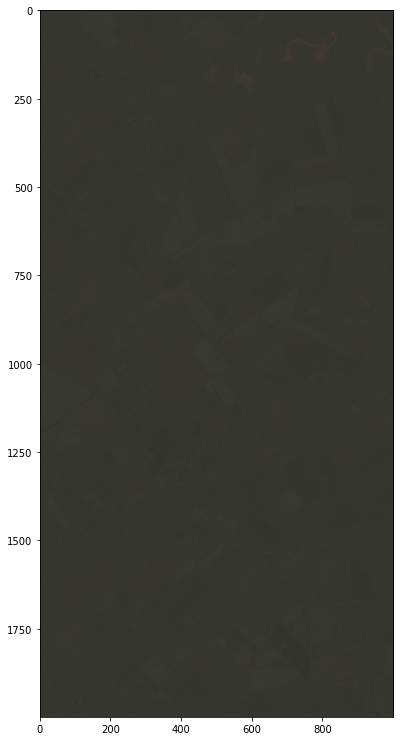

In [13]:
#criterion='mse',n_estimators=400,min_samples_split=7,min_samples_leaf=6,max_features='sqrt',n_jobs=-1
plot_composite(res)

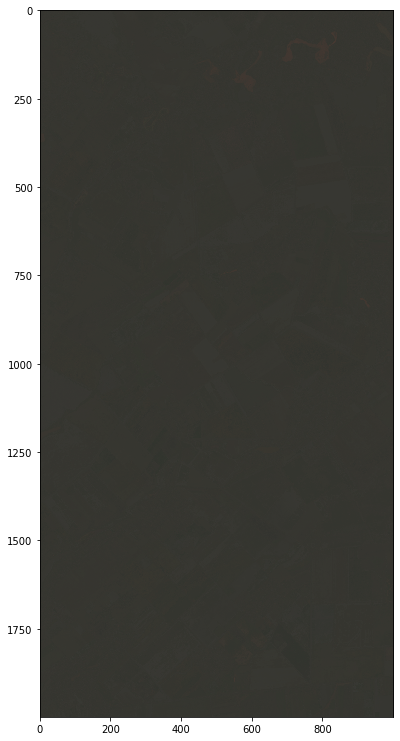

In [32]:
#criterion='mse',n_estimators=400,max_depth=50,min_samples_split=7,min_samples_leaf=10,max_features='sqrt',n_jobs=-1
plot_composite(res)

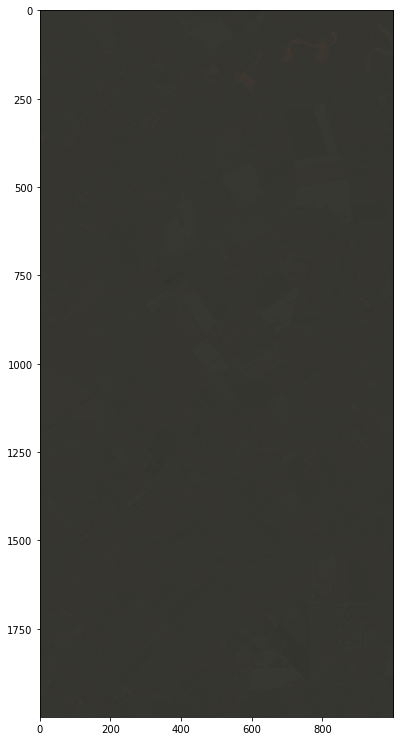

In [29]:
#criterion='mse',n_estimators=300,max_depth=10,min_samples_split=7,min_samples_leaf=5,max_features='sqrt',n_jobs=-1
plot_composite(res)

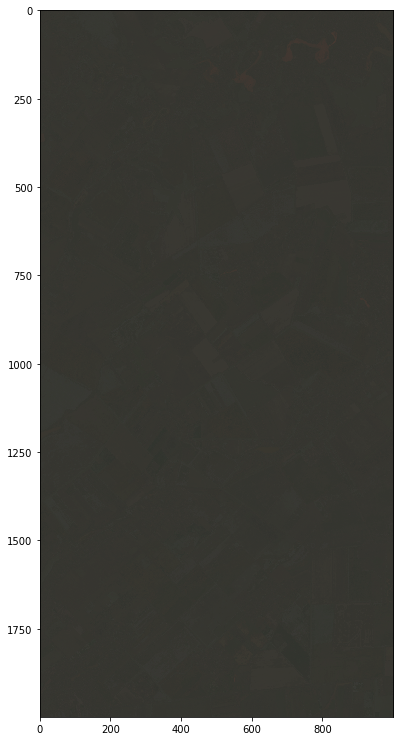

In [26]:
#criterion='mse',n_estimators=300,min_samples_split=7,min_samples_leaf=5,max_features='sqrt',n_jobs=-1
plot_composite(res)

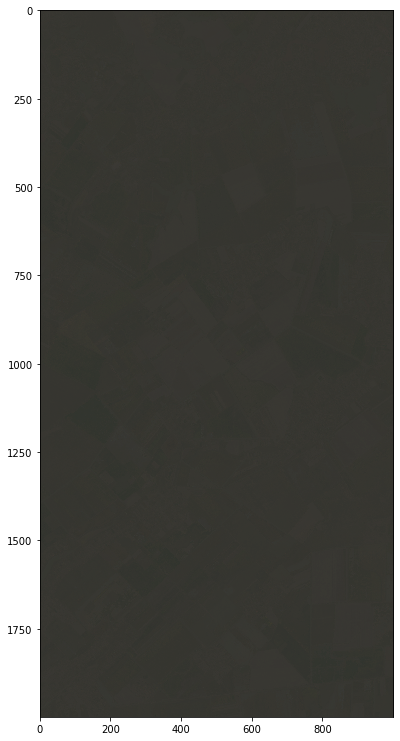

In [12]:
##criterion='mse',n_estimators=500,min_samples_split=7,min_samples_leaf=5,max_features='log2',n_jobs=-1
plot_composite(res)

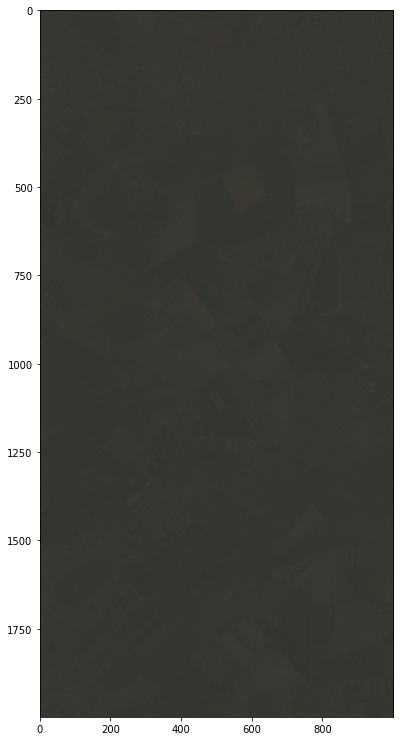

In [11]:
#criterion:='mse',n_estimators:=100,min_samples_split:=4,min_samples_leaf:=2, max_features:='sqrt', n_jobs:=-1
plot_composite(res)

## Results with mean

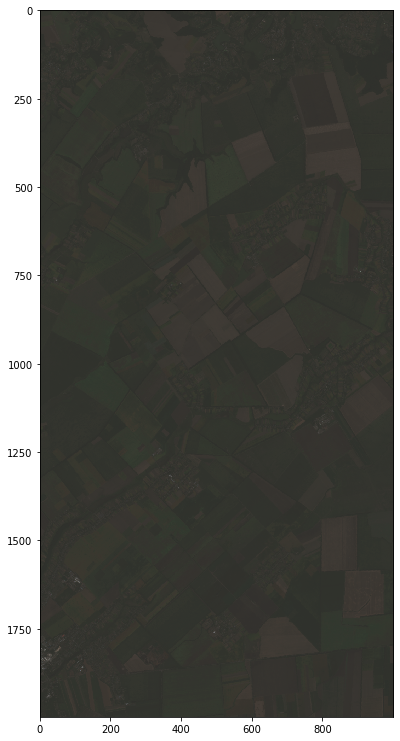

In [9]:
men = np.mean([clear_comp[:,:,1000:],res[:4,:,:]], axis=0)
plot_composite(men)

In [10]:
f = np.copy(clear_comp)
f[:,:,1000:] = men#res[:4,:,:]# men !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

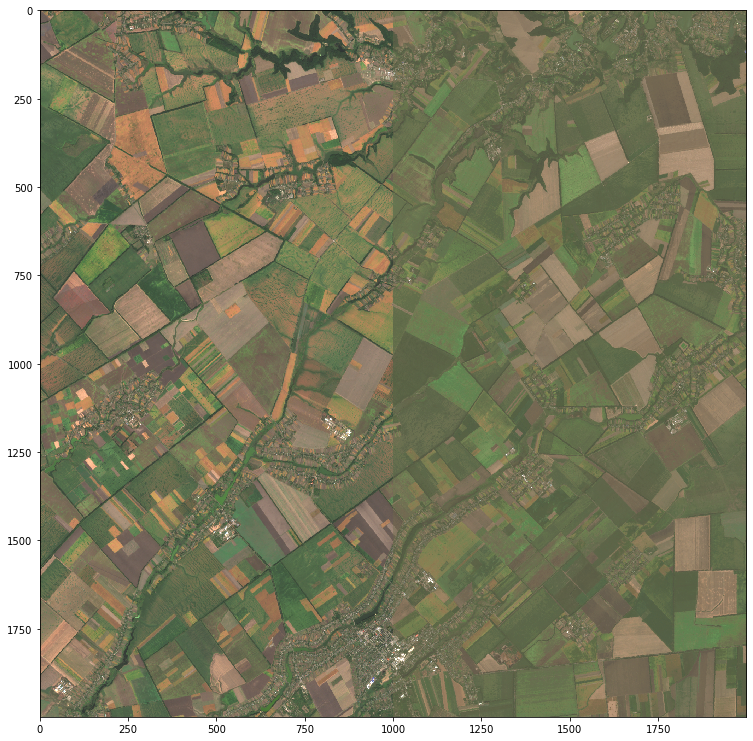

In [11]:
plot_composite(5*f)

# Stats

In [26]:
stats(Y_TRUE.reshape(-1,1), men.reshape(-1,1))

explained_variance_score:  0.6991110403608586
max_error:  4143.130851936765
mean_absolute_error:  343.1083816674399
mean_squared_error:  347786.59695475677
median_absolute_error:  102.20218873828705
r2_score:  0.6125520649060676


In [27]:
stats(Y_TRUE.reshape(-1,1),res[:4,:,:].reshape(-1,1))

explained_variance_score:  -0.5733648719325934
max_error:  6669.0
mean_absolute_error:  746.6205381904241
mean_squared_error:  1781454.354856274
median_absolute_error:  182.9037966481182
r2_score:  -0.9846101525958093


In [ ]:
def plot_band(composite,ind_band ,min_possible=0, max_possible=10000,min_inten=0.15, max_inten=1.0):
    """
    composite: - composite with bands RGBN, shape(4,x,y)

    """
    composite = composite[ind_band,:,:]
    min_rgb = min_possible
    max_rgb = max_possible
    composite = np.interp(composite, (min_rgb, max_rgb), [min_inten,max_inten])
    composite = composite.astype(float)
    figure(figsize=(13,13))
    return plt.imshow(composite)

In [14]:
def stats(y_true,y_pred):
    print("explained_variance_score: ",explained_variance_score(y_true,y_pred))
    print("max_error: ",max_error(y_true, y_pred))
    print("mean_absolute_error: ",mean_absolute_error(y_true, y_pred))
    print("mean_squared_error: ",mean_squared_error(y_true, y_pred))
    print("median_absolute_error: ",median_absolute_error(y_true, y_pred))
    print("r2_score: ",r2_score(y_true, y_pred))